# ECS 171 HW3
### CREATING A VIRTUAL CELL: PREDICTING PHENOTYPIC ANDENVIRONMENTAL CHARACTERISTICS 

## Imports and  Data Input

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.linear_model import RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, auc, precision_recall_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

bacteria = pd.read_excel("ecs171.dataset.xlsx",delim_whitespace=True)
IDS=bacteria['ID']
bacteria = bacteria.drop(columns=['ID','b4635']) 
# removed last column due to funky NaN's

In [2]:
bacteria.shape

(194, 4500)

Problem 1: Create a predictor of the bacterial growth attribute by using only the expression of the genesas attributes. Not all genes are informative for this task, so use a regularized regression tech-nique (e.g.   lasso,  ridge or elastic net) and explain what it does (we discussed these tech-niques in class, but you might have to read some more on how each method works). Whichone is the optimal constrained parameter value (usually denoted byλ)? Report the numberof features that have non-zero coefficients and the 5-fold cross-validation generalization er-ror of the technique.    

In [3]:
features=bacteria.loc[:,'b3356':] 
growth = bacteria['GrowthRate']
alpha = np.array([0.001,0.01,0.1,1,2,3,5,10,25])

In [4]:
Ridge1 = RidgeCV(alphas=alpha,cv=5)
Ridge1.fit(X=features,y=growth)

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RidgeCV(alphas=array([1.0e-03, 1.0e-02, 1.0e-01, 1.0e+00, 2.0e+00, 3.0e+00, 5.0e+00,
       1.0e+01, 2.5e+01]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [5]:
optAlpha=Ridge1.alpha_
print(optAlpha)

0.1


In [6]:
print((Ridge1.coef_!=0).sum())

4434


In [7]:
Ridge = sklearn.linear_model.Ridge(alpha=optAlpha)
errors=cross_val_score(Ridge,features,growth,cv=5)
print(1-errors)
print(1-errors.mean())

[0.42878123 0.12992284 0.33557091 0.03204945 0.17825269]
0.22091542557323918


## Problem 2:
Extend your predictor to report the confidence interval of the prediction by using the boot-strapping method. Clearly state the methodology and your assumptions. (You need not re-port the confidence interval here, you only need add that functionality to your code)

In [8]:
def report_confidence(bac):#recieve bacteria to report confidence interval for
    stats=[]
    data = bacteria
    for i in range(200): #200 iterations of bootstrapping
        Ridge2=sklearn.linear_model.Ridge(alpha=optAlpha)
        sample = resample(data, n_samples=100) 
        #we sample roughly half the dataset
        features=sample.loc[:,'b3356':] 
        growth = sample['GrowthRate']
        Ridge2.fit(features,growth)
        stats.append(Ridge2.predict(bac))
        
   
    #printing lower and upper percentiles for 95 percent
    pl = max(0, np.percentile(stats, 2.5))
    pu = min(1.0, np.percentile(stats, 97.5))
    print('The 95 percent confidence interval is between %.3f and %.3f' % (pl,pu))
    return

## Problem 3: 
Use your bootstrap model from 2 to find the confidence interval of predicted growth for abacterium whose genes are expressed exactly at the mean expression value

In [9]:
avgbac=np.array(np.mean(features)).reshape(1,4495)
print("For a hypothetical bacterium, comprised of genes expressed exactly at the mean expression value:")
print("The predicted growth rate is: %.3f" %Ridge1.predict(avgbac))
report_confidence(avgbac)

For a hypothetical bacterium, comprised of genes expressed exactly at the mean expression value:
The predicted growth rate is: 0.394
The 95 percent confidence interval is between 0.382 and 0.405


## Problem 4:
Create four separate SVM classifiers to categorize the strain type,  medium type,  environ-mental  and  gene  perturbation,  given  all  the  gene  transcriptional  profiles. The classifier should select as features a small subset of the genes, either by performing feature selection(wrapper method) or by using only the non-zero weighted features from the regularized re-gression technique of the first aim. For each classifier (4 total) report the number of featuresand the classification performance through 5-fold cross-validation by plotting the ROC andPR curves and reporting the AUC/AUPRC values.

In [10]:
#first lets delete the non zero weighted features
counter=0
zeros=[]
features=bacteria.loc[:,'b3356':].values
for c in Ridge1.coef_:
    if c == 0 :
        zeros.append(counter)
    counter +=1
features4 = np.delete(features,zeros,axis=1)

#DataPrep
strain = np.array(bacteria['Strain'])
medium = bacteria['Medium']
env = bacteria['Stress']
gene = bacteria['GenePerturbed']


#K fold initalization
skf = StratifiedKFold(n_splits=5)

In [11]:
#lets begin with strain
ohe = OneHotEncoder()
strain_onehot = ohe.fit_transform(np.array(strain).reshape(194,1))
#print(strain_onehot)
prediction=[]
actual=[]
for train,test in skf.split(features4,strain):
    strain_svc=OneVsRestClassifier(LinearSVC()) 
    currpred = strain_svc.fit(features4[train], strain_onehot[train])
    prediction.append(ohe.inverse_transform(currpred.predict(features4[test])))
    actual.append(ohe.inverse_transform(strain_onehot[test]))

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [12]:
counter1 =0
truep=[0]
falsep=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            falsep.append(falsep[-1])
            truep.append(1+truep[-1])
        else:
            truep.append(truep[-1])
            falsep.append(1+falsep[-1])
        counter2+=1
    counter1+=1
scaledtrue = [x / max(truep) for x in truep]
scaledfalse = [x / max(falsep) for x in falsep]

Text(0, 0.5, 'True Positive Rate')

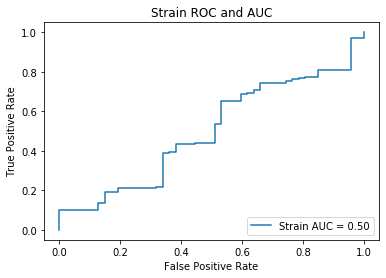

In [13]:
plt.figure()
aucscore = auc(scaledfalse,scaledtrue)
plt.title('Strain ROC and AUC')
plt.plot(scaledfalse,scaledtrue,label='Strain AUC = %0.2f' % aucscore)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


In [14]:
countertrue=0
counterfalse=0
counter1=0
prec=[1]
recall=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            #true positive
            countertrue+=1
            prec.append(countertrue/(countertrue+counterfalse))
            recall.append(recall[-1])
        else:
            #false positive
            counterfalse+=1
            recall.append(countertrue)
            #^^not sure how to calc recall with multiple classes (strains),
            #so i decided to make recall effectively the linspace from 0-1
            prec.append(prec[-1])
            
        counter2+=1
    counter1+=1
scaledprec = [x / max(prec) for x in prec]
scaledrecall = [x / max(recall) for x in recall]

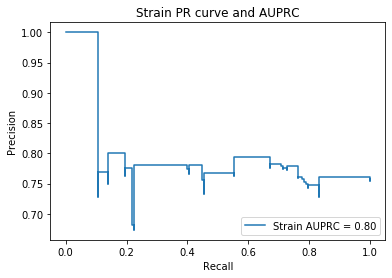

In [15]:
plt.figure()
prscore = auc(scaledrecall,scaledprec)
plt.plot(scaledrecall,scaledprec,label='Strain AUPRC = %0.2f' % prscore)
plt.title('Strain PR curve and AUPRC')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc="lower right")


In [16]:
#now lets do medium
ohe = OneHotEncoder()
medium_onehot = ohe.fit_transform(np.array(medium).reshape(194,1))
prediction=[]
actual=[]
for train,test in skf.split(features4,medium):
    medium_svc=OneVsRestClassifier(LinearSVC()) 
    currpred =  medium_svc.fit(features4[train], medium_onehot[train])
    prediction.append(ohe.inverse_transform(currpred.predict(features4[test])))
    actual.append(ohe.inverse_transform(medium_onehot[test]))

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 11 is present in all training examples.
  str(classes[c]))
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 15 is present in all training examples.
  str(classes[c]))
C:\Users\ali

Text(0, 0.5, 'True Positive Rate')

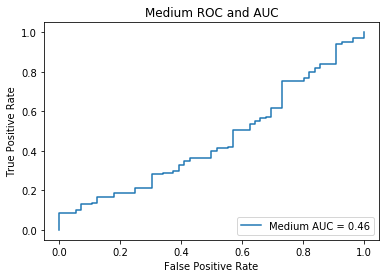

In [17]:
counter1 =0
truep=[0]
falsep=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            falsep.append(falsep[-1])
            truep.append(1+truep[-1])
        else:
            truep.append(truep[-1])
            falsep.append(1+falsep[-1])
        counter2+=1
    counter1+=1
scaledtrue = [x / max(truep) for x in truep]
scaledfalse = [x / max(falsep) for x in falsep]

plt.figure()
aucscore = auc(scaledfalse,scaledtrue)
plt.title('Medium ROC and AUC')
plt.plot(scaledfalse,scaledtrue,label='Medium AUC = %0.2f' % aucscore)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


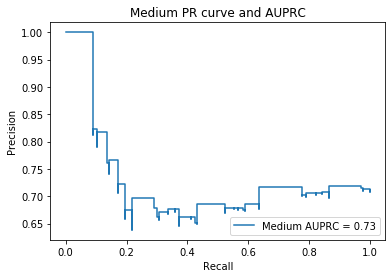

In [18]:
countertrue=0
counterfalse=0
counter1=0
prec=[1]
recall=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            #true positive
            countertrue+=1
            prec.append(countertrue/(countertrue+counterfalse))
            recall.append(recall[-1])
        else:
            #false positive
            counterfalse+=1
            recall.append(countertrue)
            #^^not sure how to calc recall with multiple classes (mediums),
            #so i decided to make recall effectively the linspace from 0-1
            prec.append(prec[-1])
            
        counter2+=1
    counter1+=1
scaledprec = [x / max(prec) for x in prec]
scaledrecall = [x / max(recall) for x in recall]

plt.figure()
prscore = auc(scaledrecall,scaledprec)
plt.plot(scaledrecall,scaledprec,label='Medium AUPRC = %0.2f' % prscore)
plt.title('Medium PR curve and AUPRC')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc="lower right")

In [19]:
#onto environmental (stress)
ohe = OneHotEncoder()
env_onehot = ohe.fit_transform(np.array(env).reshape(194,1))
prediction=[]
actual=[]
for train,test in skf.split(features4,env):
    env_svc=OneVsRestClassifier(LinearSVC()) 
    currpred =  medium_svc.fit(features4[train], env_onehot[train])
    prediction.append(ohe.inverse_transform(currpred.predict(features4[test])))
    actual.append(ohe.inverse_transform(env_onehot[test]))

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Text(0, 0.5, 'True Positive Rate')

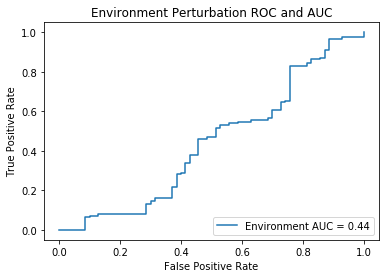

In [20]:
counter1 =0
truep=[0]
falsep=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            falsep.append(falsep[-1])
            truep.append(1+truep[-1])
        else:
            truep.append(truep[-1])
            falsep.append(1+falsep[-1])
        counter2+=1
    counter1+=1
scaledtrue = [x / max(truep) for x in truep]
scaledfalse = [x / max(falsep) for x in falsep]

plt.figure()
aucscore = auc(scaledfalse,scaledtrue)
plt.title('Environment Perturbation ROC and AUC')
plt.plot(scaledfalse,scaledtrue,label='Environment AUC = %0.2f' % aucscore)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


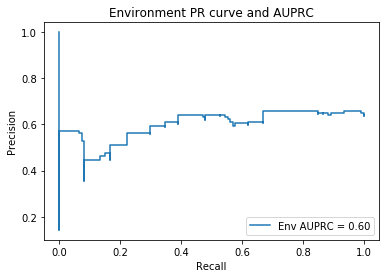

In [21]:
countertrue=0
counterfalse=0
counter1=0
prec=[1]
recall=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            #true positive
            countertrue+=1
            prec.append(countertrue/(countertrue+counterfalse))
            recall.append(recall[-1])
        else:
            #false positive
            counterfalse+=1
            recall.append(countertrue)
            #^^not sure how to calc recall with multiple classes (enviorment perturbation rates),
            #so i decided to make recall effectively the linspace from 0-1
            prec.append(prec[-1])
            
        counter2+=1
    counter1+=1
scaledprec = [x / max(prec) for x in prec]
scaledrecall = [x / max(recall) for x in recall]

plt.figure()
prscore = auc(scaledrecall,scaledprec)
plt.plot(scaledrecall,scaledprec,label='Env AUPRC = %0.2f' % prscore)
plt.title('Environment PR curve and AUPRC')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc="lower right")

In [22]:
#finally gene perturbation (stress)
ohe = OneHotEncoder()
gene_onehot = ohe.fit_transform(np.array(gene).reshape(194,1))
prediction=[]
actual=[]
for train,test in skf.split(features4,gene):
    env_svc=OneVsRestClassifier(LinearSVC()) 
    currpred =  medium_svc.fit(features4[train], gene_onehot[train])
    prediction.append(ohe.inverse_transform(currpred.predict(features4[test])))
    actual.append(ohe.inverse_transform(gene_onehot[test]))

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the numb

Text(0, 0.5, 'True Positive Rate')

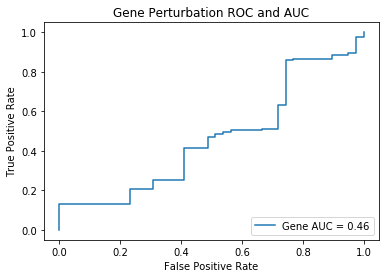

In [23]:
counter1 =0
truep=[0]
falsep=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            falsep.append(falsep[-1])
            truep.append(1+truep[-1])
        else:
            truep.append(truep[-1])
            falsep.append(1+falsep[-1])
        counter2+=1
    counter1+=1
scaledtrue = [x / max(truep) for x in truep]
scaledfalse = [x / max(falsep) for x in falsep]

plt.figure()
aucscore = auc(scaledfalse,scaledtrue)
plt.title('Gene Perturbation ROC and AUC')
plt.plot(scaledfalse,scaledtrue,label='Gene AUC = %0.2f' % aucscore)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


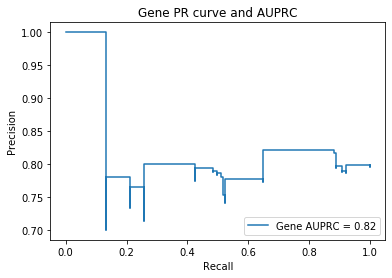

In [24]:
countertrue=0
counterfalse=0
counter1=0
prec=[1]
recall=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            #true positive
            countertrue+=1
            prec.append(countertrue/(countertrue+counterfalse))
            recall.append(recall[-1])
        else:
            #false positive
            counterfalse+=1
            recall.append(countertrue)
            #^^not sure how to calc recall with multiple classes (gene perturbance rates),
            #so i decided to make recall effectively the linspace from 0-1
            prec.append(prec[-1])
            
        counter2+=1
    counter1+=1
scaledprec = [x / max(prec) for x in prec]
scaledrecall = [x / max(recall) for x in recall]

plt.figure()
prscore = auc(scaledrecall,scaledprec)
plt.plot(scaledrecall,scaledprec,label='Gene AUPRC = %0.2f' % prscore)
plt.title('Gene PR curve and AUPRC')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc="lower right")

## Problem 5:
Create one composite SVM classifier to simultaneously predict medium and environmentalperturbations and report the 10-fold cross-validation AUC/AUPRC value. Does this classifierperform better or worse than the two individual classifiers together for these predictions?That is, are we better off building one composite or two separate classifiers to simultane-ously predict these two features? What is the baseline prediction performance (null hypoth-esis)?

In [25]:
#lets copy the non zero weighted features from p4
features5=features4

#DataPrep
medium = bacteria['Medium']
env = bacteria['Stress']
mediumenv=medium+env


#10 fold initalization
skf = StratifiedKFold(n_splits=10)
from scipy import stats

In [26]:
#Let's begin with the baseline prediction, to compare our results later
#For the baseline,  we will find the most common combined feature and guess it every time
ohe = OneHotEncoder()
mediumenv_onehot = ohe.fit_transform(np.array(mediumenv).reshape(194,1))

maxfreq=0
for i in np.unique(mediumenv_onehot):
    ifreq = (mediumenv_onehot==i).sum()
    if ifreq > maxfreq:
        maxfreq=ifreq
        ans=i
alwayspredict=ans
#always predict now contains the maximally occuring one hot value

prediction=[]
actual=[]
for train,test in skf.split(features5,mediumenv):
    mediumenv_svc=OneVsRestClassifier(LinearSVC()) 
    currpred = strain_svc.fit(features5[train], mediumenv_onehot[train])
    prediction.append(ohe.inverse_transform(alwayspredict))
    actual.append(ohe.inverse_transform(mediumenv_onehot[test]))

C:\Users\ali_h\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning:

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Text(0, 0.5, 'True Positive Rate')

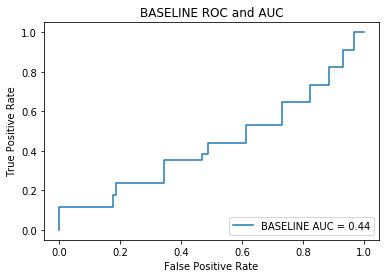

In [27]:
counter1 =0
truep=[0]
falsep=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            falsep.append(falsep[-1])
            truep.append(1+truep[-1])
        else:
            truep.append(truep[-1])
            falsep.append(1+falsep[-1])
        counter2+=1
    counter1+=1
scaledtrue = [x / max(truep) for x in truep]
scaledfalse = [x / max(falsep) for x in falsep]

plt.figure()
aucscore = auc(scaledfalse,scaledtrue)
plt.title('BASELINE ROC and AUC')
plt.plot(scaledfalse,scaledtrue,label='BASELINE AUC = %0.2f' % aucscore)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

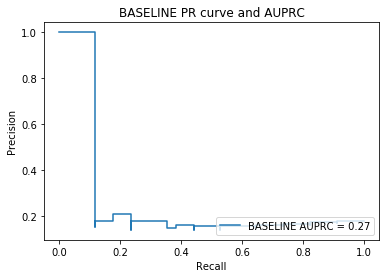

In [28]:
countertrue=0
counterfalse=0
counter1=0
prec=[1]
recall=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            #true positive
            countertrue+=1
            prec.append(countertrue/(countertrue+counterfalse))
            recall.append(recall[-1])
        else:
            #false positive
            counterfalse+=1
            recall.append(countertrue)
            #^^not sure how to calc recall with multiple classes,
            #so i decided to make recall effectively the linspace from 0-1
            prec.append(prec[-1])
            
        counter2+=1
    counter1+=1
scaledprec = [x / max(prec) for x in prec]
scaledrecall = [x / max(recall) for x in recall]

plt.figure()
prscore = auc(scaledrecall,scaledprec)
plt.plot(scaledrecall,scaledprec,label='BASELINE AUPRC = %0.2f' % prscore)
plt.title('BASELINE PR curve and AUPRC')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc="lower right")

In [29]:
#calculating both features simultaneously
ohe = OneHotEncoder()
mediumenv_onehot = ohe.fit_transform(np.array(mediumenv).reshape(194,1))
prediction=[]
actual=[]
for train,test in skf.split(features5,gene):
    env_svc=OneVsRestClassifier(LinearSVC()) 
    currpred =  medium_svc.fit(features5[train], mediumenv_onehot[train])
    prediction.append(ohe.inverse_transform(currpred.predict(features5[test])))
    actual.append(ohe.inverse_transform(mediumenv_onehot[test]))

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 15 is present in all training examples.
  str(classes[c]))
C:\Users\ali

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Text(0, 0.5, 'True Positive Rate')

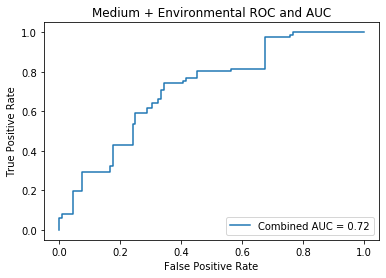

In [30]:
counter1 =0
truep=[0]
falsep=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            falsep.append(falsep[-1])
            truep.append(1+truep[-1])
        else:
            truep.append(truep[-1])
            falsep.append(1+falsep[-1])
        counter2+=1
    counter1+=1
scaledtrue = [x / max(truep) for x in truep]
scaledfalse = [x / max(falsep) for x in falsep]

plt.figure()
aucscore = auc(scaledfalse,scaledtrue)
plt.title('Medium + Environmental ROC and AUC')
plt.plot(scaledfalse,scaledtrue,label='Combined AUC = %0.2f' % aucscore)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

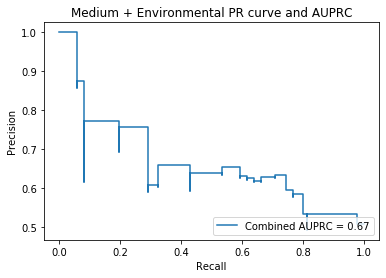

In [31]:
countertrue=0
counterfalse=0
counter1=0
prec=[1]
recall=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            #true positive
            countertrue+=1
            prec.append(countertrue/(countertrue+counterfalse))
            recall.append(recall[-1])
        else:
            #false positive
            counterfalse+=1
            recall.append(countertrue)
            #^^not sure how to calc recall with multiple classes,
            #so i decided to make recall effectively the linspace from 0-1
            prec.append(prec[-1])
            
        counter2+=1
    counter1+=1
scaledprec = [x / max(prec) for x in prec]
scaledrecall = [x / max(recall) for x in recall]

plt.figure()
prscore = auc(scaledrecall,scaledprec)
plt.plot(scaledrecall,scaledprec,label='Combined AUPRC = %0.2f' % prscore)
plt.title('Medium + Environmental PR curve and AUPRC')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc="lower right")

## Problem 6:
Reduce the dimensionality of gene expression profiles (i.e. last 4496 columns) to two dimen-sions only using both Principal Component Analysis (PCA) and t-SNE. Visualize the datasetin 2-d space using PCA and t-SNE separately (report two plots).

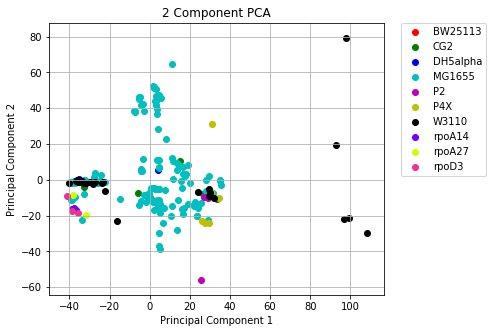

In [32]:
features6=bacteria.loc[:,'b3356':].values
pca = PCA(n_components=2)
#normalize the dataset first
pcafeatures = pd.DataFrame(pca.fit_transform(StandardScaler().fit_transform(features6)))
strains = np.unique(bacteria['Strain'].values)
#adding the strains to the dataframe for visualization
pcafeatures.insert(2, "strain",bacteria['Strain'].values, True) 


plt.figure(figsize = (6,5))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 Component PCA')
#plt.scatter(pcafeatures[:,0],pcafeatures[:,1],c='r')

targets = strains
colors = ['r', 'g', 'b','c','m','y','k','#7300f7','#d0ff00','#eb348f']
for target, color in zip(targets,colors):
    #print(target)
    indicesToKeep = pcafeatures['strain'] == target
    #print(indicesToKeep)
    plt.scatter(pcafeatures.loc[indicesToKeep,0]
               , pcafeatures.loc[indicesToKeep,1]
               , c = color)
plt.legend(targets,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid()

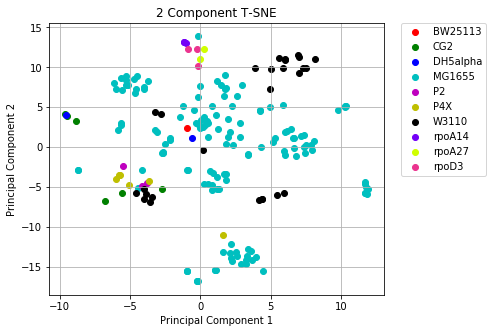

In [33]:
t= TSNE(n_components=2)
#normalize the dataset first
pcafeatures = pd.DataFrame(t.fit_transform(StandardScaler().fit_transform(features6)))
strains = np.unique(bacteria['Strain'].values)
#adding the strains to the dataframe for visualization
pcafeatures.insert(2, "strain",bacteria['Strain'].values, True) 


plt.figure(figsize = (6,5))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 Component T-SNE')
#plt.scatter(pcafeatures[:,0],pcafeatures[:,1],c='r')

targets = strains
colors = ['r', 'g', 'b','c','m','y','k','#7300f7','#d0ff00','#eb348f']
for target, color in zip(targets,colors):
    #print(target)
    indicesToKeep = pcafeatures['strain'] == target
    #print(indicesToKeep)
    plt.scatter(pcafeatures.loc[indicesToKeep,0]
               , pcafeatures.loc[indicesToKeep,1]
               , c = color)
plt.legend(targets,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid()


## Problem 7:
Redo the problem 4 but instead of feature selection, use dimensionality reduction resultsof problem 6 and report the 10-fold cross validation AUC/AUPRC values.   For each of thefour classifiers, what is the best pre-processing approach (feature selection, PCA or t-SNE)?

In [34]:
features7=bacteria.loc[:,'b3356':].values

#DataPrep
strain = np.array(bacteria['Strain'])
medium = bacteria['Medium']
env = bacteria['Stress']
gene = bacteria['GenePerturbed']


#K fold initalization
skf = StratifiedKFold(n_splits=10)


pca7=pca.fit_transform(features7)
sne7=t.fit_transform(features7)

In [35]:
#lets begin with strain using PCA
ohe = OneHotEncoder()
strain_onehot = ohe.fit_transform(np.array(strain).reshape(194,1))
#print(strain_onehot)
prediction=[]
actual=[]
for train,test in skf.split(pca7,strain):
    strain_svc=OneVsRestClassifier(LinearSVC()) 
    currpred = strain_svc.fit(pca7[train], strain_onehot[train])
    prediction.append(ohe.inverse_transform(currpred.predict(pca7[test])))
    actual.append(ohe.inverse_transform(strain_onehot[test]))

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the num

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Text(0, 0.5, 'True Positive Rate')

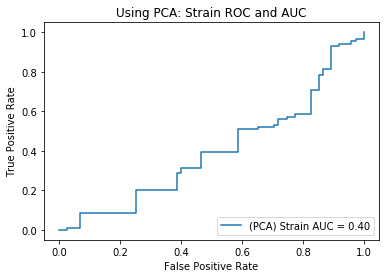

In [36]:
counter1 =0
truep=[0]
falsep=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            falsep.append(falsep[-1])
            truep.append(1+truep[-1])
        else:
            truep.append(truep[-1])
            falsep.append(1+falsep[-1])
        counter2+=1
    counter1+=1
scaledtrue = [x / max(truep) for x in truep]
scaledfalse = [x / max(falsep) for x in falsep]


plt.figure()
aucscore = auc(scaledfalse,scaledtrue)
plt.title('Using PCA: Strain ROC and AUC')
plt.plot(scaledfalse,scaledtrue,label='(PCA) Strain AUC = %0.2f' % aucscore)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

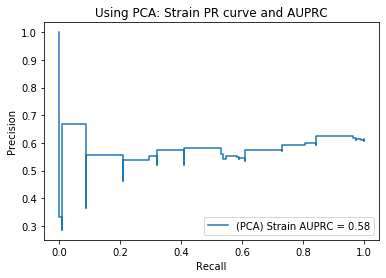

In [37]:
countertrue=0
counterfalse=0
counter1=0
prec=[1]
recall=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            #true positive
            countertrue+=1
            prec.append(countertrue/(countertrue+counterfalse))
            recall.append(recall[-1])
        else:
            #false positive
            counterfalse+=1
            recall.append(countertrue)
            #^^not sure how to calc recall with multiple classes (strains),
            #so i decided to make recall effectively the linspace from 0-1
            prec.append(prec[-1])
            
        counter2+=1
    counter1+=1
scaledprec = [x / max(prec) for x in prec]
scaledrecall = [x / max(recall) for x in recall]

plt.figure()
prscore = auc(scaledrecall,scaledprec)
plt.plot(scaledrecall,scaledprec,label='(PCA) Strain AUPRC = %0.2f' % prscore)
plt.title('Using PCA: Strain PR curve and AUPRC')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")

In [38]:
#now, strain using t-SNE
ohe = OneHotEncoder()
strain_onehot = ohe.fit_transform(np.array(strain).reshape(194,1))
#print(strain_onehot)
prediction=[]
actual=[]
for train,test in skf.split(sne7,strain):
    strain_svc=OneVsRestClassifier(LinearSVC()) 
    currpred = strain_svc.fit(sne7[train], strain_onehot[train])
    prediction.append(ohe.inverse_transform(currpred.predict(sne7[test])))
    actual.append(ohe.inverse_transform(strain_onehot[test]))

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the num

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Text(0, 0.5, 'True Positive Rate')

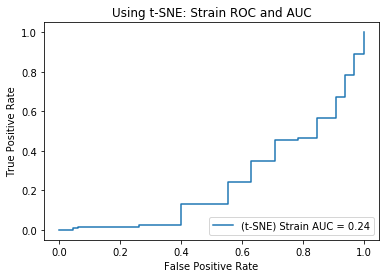

In [39]:
counter1 =0
truep=[0]
falsep=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            falsep.append(falsep[-1])
            truep.append(1+truep[-1])
        else:
            truep.append(truep[-1])
            falsep.append(1+falsep[-1])
        counter2+=1
    counter1+=1
scaledtrue = [x / max(truep) for x in truep]
scaledfalse = [x / max(falsep) for x in falsep]

plt.figure()
aucscore = auc(scaledfalse,scaledtrue)
plt.title('Using t-SNE: Strain ROC and AUC')
plt.plot(scaledfalse,scaledtrue,label='(t-SNE) Strain AUC = %0.2f' % aucscore)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

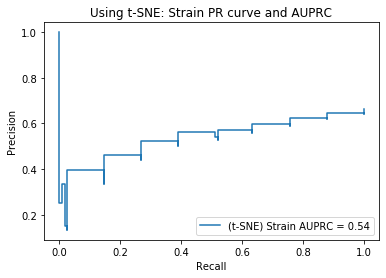

In [40]:
countertrue=0
counterfalse=0
counter1=0
prec=[1]
recall=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            #true positive
            countertrue+=1
            prec.append(countertrue/(countertrue+counterfalse))
            recall.append(recall[-1])
        else:
            #false positive
            counterfalse+=1
            recall.append(countertrue)
            #^^not sure how to calc recall with multiple classes (strains),
            #so i decided to make recall effectively the linspace from 0-1
            prec.append(prec[-1])
            
        counter2+=1
    counter1+=1
scaledprec = [x / max(prec) for x in prec]
scaledrecall = [x / max(recall) for x in recall]

plt.figure()
prscore = auc(scaledrecall,scaledprec)
plt.plot(scaledrecall,scaledprec,label='(t-SNE) Strain AUPRC = %0.2f' % prscore)
plt.title('Using t-SNE: Strain PR curve and AUPRC')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc="lower right")

In [41]:
# medium using PCA
ohe = OneHotEncoder()
medium_onehot = ohe.fit_transform(np.array(medium).reshape(194,1))
#print(strain_onehot)
prediction=[]
actual=[]
for train,test in skf.split(pca7,medium):
    strain_svc=OneVsRestClassifier(LinearSVC()) 
    currpred = strain_svc.fit(pca7[train], medium_onehot[train])
    prediction.append(ohe.inverse_transform(currpred.predict(pca7[test])))
    actual.append(ohe.inverse_transform(medium_onehot[test]))

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to c

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Text(0, 0.5, 'True Positive Rate')

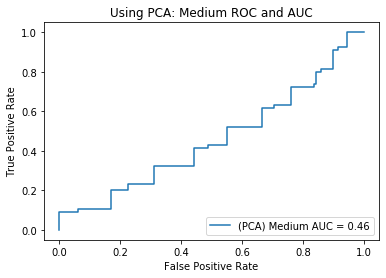

In [42]:
counter1 =0
truep=[0]
falsep=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            falsep.append(falsep[-1])
            truep.append(1+truep[-1])
        else:
            truep.append(truep[-1])
            falsep.append(1+falsep[-1])
        counter2+=1
    counter1+=1
scaledtrue = [x / max(truep) for x in truep]
scaledfalse = [x / max(falsep) for x in falsep]


plt.figure()
aucscore = auc(scaledfalse,scaledtrue)
plt.title('Using PCA: Medium ROC and AUC')
plt.plot(scaledfalse,scaledtrue,label='(PCA) Medium AUC = %0.2f' % aucscore)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

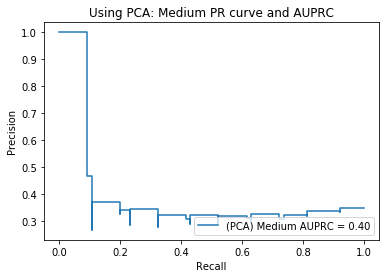

In [43]:
countertrue=0
counterfalse=0
counter1=0
prec=[1]
recall=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            #true positive
            countertrue+=1
            prec.append(countertrue/(countertrue+counterfalse))
            recall.append(recall[-1])
        else:
            #false positive
            counterfalse+=1
            recall.append(countertrue)
            #^^not sure how to calc recall with multiple classes (strains),
            #so i decided to make recall effectively the linspace from 0-1
            prec.append(prec[-1])
            
        counter2+=1
    counter1+=1
scaledprec = [x / max(prec) for x in prec]
scaledrecall = [x / max(recall) for x in recall]

plt.figure()
prscore = auc(scaledrecall,scaledprec)
plt.plot(scaledrecall,scaledprec,label='(PCA) Medium AUPRC = %0.2f' % prscore)
plt.title('Using PCA: Medium PR curve and AUPRC')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")

In [44]:
#now, medium using t-SNE
ohe = OneHotEncoder()
medium_onehot = ohe.fit_transform(np.array(medium).reshape(194,1))
#print(strain_onehot)
prediction=[]
actual=[]
for train,test in skf.split(sne7,medium):
    strain_svc=OneVsRestClassifier(LinearSVC()) 
    currpred = strain_svc.fit(sne7[train], medium_onehot[train])
    prediction.append(ohe.inverse_transform(currpred.predict(sne7[test])))
    actual.append(ohe.inverse_transform(medium_onehot[test]))

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to c

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0, 0.5, 'True Positive Rate')

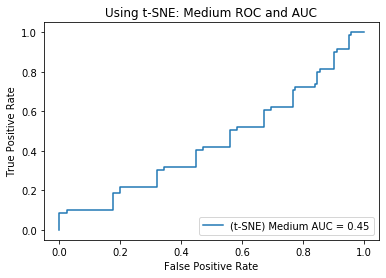

In [45]:
counter1 =0
truep=[0]
falsep=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            falsep.append(falsep[-1])
            truep.append(1+truep[-1])
        else:
            truep.append(truep[-1])
            falsep.append(1+falsep[-1])
        counter2+=1
    counter1+=1
scaledtrue = [x / max(truep) for x in truep]
scaledfalse = [x / max(falsep) for x in falsep]

plt.figure()
aucscore = auc(scaledfalse,scaledtrue)
plt.title('Using t-SNE: Medium ROC and AUC')
plt.plot(scaledfalse,scaledtrue,label='(t-SNE) Medium AUC = %0.2f' % aucscore)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

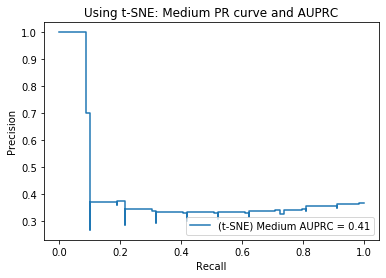

In [46]:
countertrue=0
counterfalse=0
counter1=0
prec=[1]
recall=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            #true positive
            countertrue+=1
            prec.append(countertrue/(countertrue+counterfalse))
            recall.append(recall[-1])
        else:
            #false positive
            counterfalse+=1
            recall.append(countertrue)
            #^^not sure how to calc recall with multiple classes (strains),
            #so i decided to make recall effectively the linspace from 0-1
            prec.append(prec[-1])
            
        counter2+=1
    counter1+=1
scaledprec = [x / max(prec) for x in prec]
scaledrecall = [x / max(recall) for x in recall]

plt.figure()
prscore = auc(scaledrecall,scaledprec)
plt.plot(scaledrecall,scaledprec,label='(t-SNE) Medium AUPRC = %0.2f' % prscore)
plt.title('Using t-SNE: Medium PR curve and AUPRC')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc="lower right")

In [47]:
# Environment using PCA
ohe = OneHotEncoder()
env_onehot = ohe.fit_transform(np.array(env).reshape(194,1))
#print(strain_onehot)
prediction=[]
actual=[]
for train,test in skf.split(pca7,env):
    strain_svc=OneVsRestClassifier(LinearSVC()) 
    currpred = strain_svc.fit(pca7[train], env_onehot[train])
    prediction.append(ohe.inverse_transform(currpred.predict(pca7[test])))
    actual.append(ohe.inverse_transform(env_onehot[test]))

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to c

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Text(0, 0.5, 'True Positive Rate')

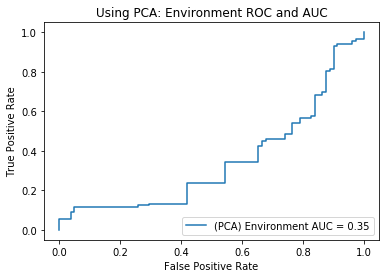

In [48]:
counter1 =0
truep=[0]
falsep=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            falsep.append(falsep[-1])
            truep.append(1+truep[-1])
        else:
            truep.append(truep[-1])
            falsep.append(1+falsep[-1])
        counter2+=1
    counter1+=1
scaledtrue = [x / max(truep) for x in truep]
scaledfalse = [x / max(falsep) for x in falsep]


plt.figure()
aucscore = auc(scaledfalse,scaledtrue)
plt.title('Using PCA: Environment ROC and AUC')
plt.plot(scaledfalse,scaledtrue,label='(PCA) Environment AUC = %0.2f' % aucscore)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

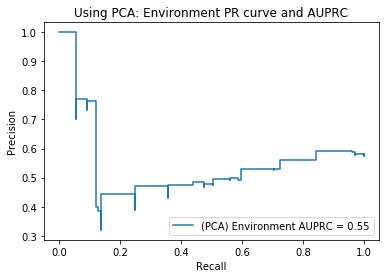

In [49]:
countertrue=0
counterfalse=0
counter1=0
prec=[1]
recall=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            #true positive
            countertrue+=1
            prec.append(countertrue/(countertrue+counterfalse))
            recall.append(recall[-1])
        else:
            #false positive
            counterfalse+=1
            recall.append(countertrue)
            #^^not sure how to calc recall with multiple classes (strains),
            #so i decided to make recall effectively the linspace from 0-1
            prec.append(prec[-1])
            
        counter2+=1
    counter1+=1
scaledprec = [x / max(prec) for x in prec]
scaledrecall = [x / max(recall) for x in recall]

plt.figure()
prscore = auc(scaledrecall,scaledprec)
plt.plot(scaledrecall,scaledprec,label='(PCA) Environment AUPRC = %0.2f' % prscore)
plt.title('Using PCA: Environment PR curve and AUPRC')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")

In [50]:
#now, env using t-SNE
ohe = OneHotEncoder()
env_onehot = ohe.fit_transform(np.array(env).reshape(194,1))
#print(strain_onehot)
prediction=[]
actual=[]
for train,test in skf.split(sne7,env):
    strain_svc=OneVsRestClassifier(LinearSVC()) 
    currpred = strain_svc.fit(sne7[train], env_onehot[train])
    prediction.append(ohe.inverse_transform(currpred.predict(sne7[test])))
    actual.append(ohe.inverse_transform(env_onehot[test]))

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to c

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Text(0, 0.5, 'True Positive Rate')

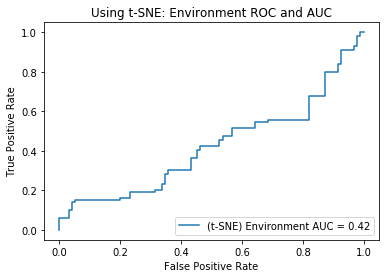

In [51]:
counter1 =0
truep=[0]
falsep=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            falsep.append(falsep[-1])
            truep.append(1+truep[-1])
        else:
            truep.append(truep[-1])
            falsep.append(1+falsep[-1])
        counter2+=1
    counter1+=1
scaledtrue = [x / max(truep) for x in truep]
scaledfalse = [x / max(falsep) for x in falsep]

plt.figure()
aucscore = auc(scaledfalse,scaledtrue)
plt.title('Using t-SNE: Environment ROC and AUC')
plt.plot(scaledfalse,scaledtrue,label='(t-SNE) Environment AUC = %0.2f' % aucscore)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

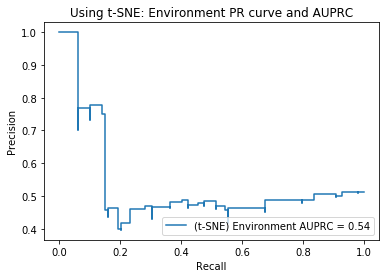

In [52]:
countertrue=0
counterfalse=0
counter1=0
prec=[1]
recall=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            #true positive
            countertrue+=1
            prec.append(countertrue/(countertrue+counterfalse))
            recall.append(recall[-1])
        else:
            #false positive
            counterfalse+=1
            recall.append(countertrue)
            #^^not sure how to calc recall with multiple classes (strains),
            #so i decided to make recall effectively the linspace from 0-1
            prec.append(prec[-1])
            
        counter2+=1
    counter1+=1
scaledprec = [x / max(prec) for x in prec]
scaledrecall = [x / max(recall) for x in recall]

plt.figure()
prscore = auc(scaledrecall,scaledprec)
plt.plot(scaledrecall,scaledprec,label='(t-SNE) Environment AUPRC = %0.2f' % prscore)
plt.title('Using t-SNE: Environment PR curve and AUPRC')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc="lower right")

In [53]:
# gene using PCA
ohe = OneHotEncoder()
gene_onehot = ohe.fit_transform(np.array(gene).reshape(194,1))
#print(strain_onehot)
prediction=[]
actual=[]
for train,test in skf.split(pca7,gene):
    strain_svc=OneVsRestClassifier(LinearSVC()) 
    currpred = strain_svc.fit(pca7[train], gene_onehot[train])
    prediction.append(ohe.inverse_transform(currpred.predict(pca7[test])))
    actual.append(ohe.inverse_transform(gene_onehot[test]))

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to c

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Text(0, 0.5, 'True Positive Rate')

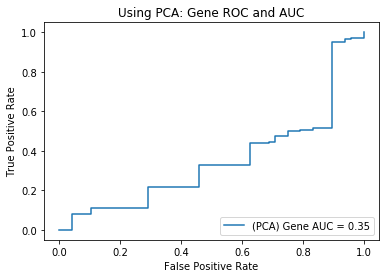

In [54]:
counter1 =0
truep=[0]
falsep=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            falsep.append(falsep[-1])
            truep.append(1+truep[-1])
        else:
            truep.append(truep[-1])
            falsep.append(1+falsep[-1])
        counter2+=1
    counter1+=1
scaledtrue = [x / max(truep) for x in truep]
scaledfalse = [x / max(falsep) for x in falsep]


plt.figure()
aucscore = auc(scaledfalse,scaledtrue)
plt.title('Using PCA: Gene ROC and AUC')
plt.plot(scaledfalse,scaledtrue,label='(PCA) Gene AUC = %0.2f' % aucscore)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

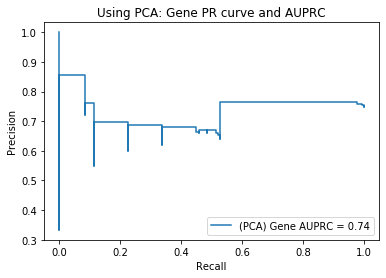

In [55]:
countertrue=0
counterfalse=0
counter1=0
prec=[1]
recall=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            #true positive
            countertrue+=1
            prec.append(countertrue/(countertrue+counterfalse))
            recall.append(recall[-1])
        else:
            #false positive
            counterfalse+=1
            recall.append(countertrue)
            #^^not sure how to calc recall with multiple classes (strains),
            #so i decided to make recall effectively the linspace from 0-1
            prec.append(prec[-1])
            
        counter2+=1
    counter1+=1
scaledprec = [x / max(prec) for x in prec]
scaledrecall = [x / max(recall) for x in recall]

plt.figure()
prscore = auc(scaledrecall,scaledprec)
plt.plot(scaledrecall,scaledprec,label='(PCA) Gene AUPRC = %0.2f' % prscore)
plt.title('Using PCA: Gene PR curve and AUPRC')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")

In [56]:
#finally, gene using t-SNE
ohe = OneHotEncoder()
gene_onehot = ohe.fit_transform(np.array(gene).reshape(194,1))
#print(strain_onehot)
prediction=[]
actual=[]
for train,test in skf.split(sne7,gene):
    strain_svc=OneVsRestClassifier(LinearSVC()) 
    currpred = strain_svc.fit(sne7[train], gene_onehot[train])
    prediction.append(ohe.inverse_transform(currpred.predict(sne7[test])))
    actual.append(ohe.inverse_transform(gene_onehot[test]))

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to c

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ali_h\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Text(0, 0.5, 'True Positive Rate')

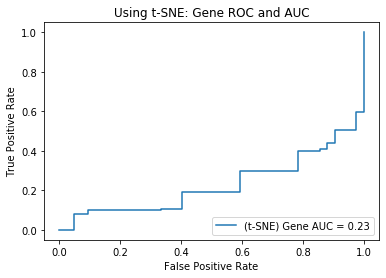

In [57]:
counter1 =0
truep=[0]
falsep=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            falsep.append(falsep[-1])
            truep.append(1+truep[-1])
        else:
            truep.append(truep[-1])
            falsep.append(1+falsep[-1])
        counter2+=1
    counter1+=1
scaledtrue = [x / max(truep) for x in truep]
scaledfalse = [x / max(falsep) for x in falsep]

plt.figure()
aucscore = auc(scaledfalse,scaledtrue)
plt.title('Using t-SNE: Gene ROC and AUC')
plt.plot(scaledfalse,scaledtrue,label='(t-SNE) Gene AUC = %0.2f' % aucscore)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

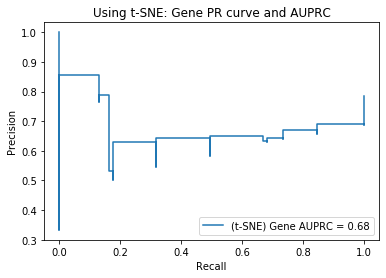

In [59]:
countertrue=0
counterfalse=0
counter1=0
prec=[1]
recall=[0]
for i in actual:
    counter2=0
    for j in i:
        p=prediction[counter1]
        if(j==p[counter2]):
            #true positive
            countertrue+=1
            prec.append(countertrue/(countertrue+counterfalse))
            recall.append(recall[-1])
        else:
            #false positive
            counterfalse+=1
            recall.append(countertrue)
            #^^not sure how to calc recall with multiple classes (strains),
            #so i decided to make recall effectively the linspace from 0-1
            prec.append(prec[-1])
            
        counter2+=1
    counter1+=1
scaledprec = [x / max(prec) for x in prec]
scaledrecall = [x / max(recall) for x in recall]

plt.figure()
prscore = auc(scaledrecall,scaledprec)
plt.plot(scaledrecall,scaledprec,label='(t-SNE) Gene AUPRC = %0.2f' % prscore)
plt.title('Using t-SNE: Gene PR curve and AUPRC')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc="lower right")